In [76]:
from sys import exit
from heapq import nsmallest
import sys
import math

In [77]:
class FileIO():
    def open_all_files(self):
        z0_1 = open('HR0_1.csv')
        z0_2 = open('HR0_2.csv')
        z1_1 = open('HR1_1.csv')
        z1_2 = open('HR1_2.csv')

        z0_1_lines = z0_1.readlines()
        z0_2_lines = z0_2.readlines()
        z1_1_lines = z1_1.readlines()
        z1_2_lines = z1_2.readlines()

        return z0_1_lines, z0_2_lines, z1_1_lines, z1_2_lines


    def sort_all(self, z0_1, z0_2, z1_1, z1_2):
        pr_values = []
        tr_values = []
        values_z0 = []
        values_z1 = []

        pr1 = z0_1[3].split(',')
        pr2 = z0_2[3].split(',')
        pr2.remove(pr2[0])

        pr_values = pr1 + pr2
        pr_values = [float(i) for i in pr_values]

        for i in range(4, len(z0_2)):
            line = z0_1[i].split(',')
            line2 = z0_2[i].split(',')

            line = [float(i) for i in line]
            line2 = [float(i) for i in line2]

            line.remove(line[0])
            line.remove(line[len(line) - 1])
            line2.remove(line2[0])

            values_z0.append(line + line2)

        for i in range(4, len(z1_1)):
            line = z1_1[i].split(',')
            line2 = z1_2[i].split(',')

            line = [float(i) for i in line]
            line2 = [float(i) for i in line2]

            first_value = line[0]
            tr_values.append(first_value)

            line.remove(first_value)
            line.remove(line[len(line) - 1])
            line2.remove(line2[0])

            values_z1.append(line + line2)

        for i in range(len(z1_1), len(z1_2)):
            line = []

            for j in range (0, 7):
                line.append(float('NaN'))

            line2 = z1_2[i].split(',')
            line2 = [float(i) for i in line2]

            tr_values.append(line2[0])
            line2.remove(line2[0])

            values_z1.append(line + line2)

        tr_values = [float(i) for i in tr_values]
        
       # print tr_values
        return pr_values, tr_values, values_z0, values_z1

In [78]:
#files = FileIO()
#a, b, c, d = files.open_all_files()
#files.sort_all(a, b, c, d)

In [79]:
class Calculation():
    def calculate_z(self, cr_temp, cr_pressure, acentric, temp, pressure):

        tr = float(temp) / float(cr_temp)
        pr = float(pressure) / float(cr_pressure)

        a, b, c, d = FileIO().open_all_files()
        e, f, g, h = FileIO().sort_all(a, b, c, d)
        #z0, z1 = find_value(pr, tr, e, f, g, h)
        z0, z1 = SearchSys().find_value(pr, tr, e, f, g, h)

        z = z0 + acentric * z1

        return z0, z1, z


    def temp_inter(self, cr_temp, cr_pressure, acentric, pressure, z):
        a, b, c, d = FileIO().open_all_files()
        pr_val, tr_val, val_z0, val_z1 = FileIO().sort_all(a, b, c, d)

        acentric = float(acentric)
        answer = SearchSys().interpolate(cr_pressure, pressure, cr_temp, None, z, acentric,
                             pr_val, tr_val, val_z0, val_z1)
        return answer


    def pressure_inter(self, cr_temp, cr_pressure, acentric, temp, z):
        a, b, c, d = FileIO().open_all_files()
        pr_val, tr_val, val_z0, val_z1 = FileIO().sort_all(a, b, c, d)

        acentric = float(acentric)
        answer = SearchSys().interpolate(cr_pressure, None, cr_temp, temp, z, acentric,
                             pr_val, tr_val, val_z0, val_z1)
        return answer

In [80]:
class SearchSys():
    def find_value(self, pr, tr, pr_val, tr_val, val_z0, val_z1):
        
        press = float(pr)
        temp = float(tr)

        x0_pr, x0_tr = None, None

        if temp > 1.7 and press < 1:
            return float('NaN'), float('NaN')
        elif temp > 1.8 and press > 1:
            return float('NaN'), float('NaN')
        elif temp < 0.3:
            return float('NaN'), float('NaN')
        else:
            try:
                pr_index = pr_val.index(press)
            except ValueError, e:
                try:
                    tr_index = tr_val.index(temp)
                    # Pr is not in table, Tr is in table
                    x0_pr, x1_pr = self.one_var_inter(pr_val, press)
                except ValueError, e:
                    # Pr and Tr not in table
                    return self.two_var_inter(press, temp, pr_val, tr_val, val_z0, val_z1)

            try:
                tr_index = tr_val.index(temp)
            except ValueError, e:
                # Tr is not in table, Pr is in table
                x0_tr, x1_tr = self.one_var_inter(tr_val, temp)

            if x0_pr != None and x0_tr == None: # interpolation of Pr value
                val = press
                x0, x1 = x0_pr, x1_pr

                y0_z0, y0_z1 = self.find_value(x0_pr, temp, pr_val, tr_val, val_z0, val_z1)
                y1_z0, y1_z1 = self.find_value(x1_pr, temp, pr_val, tr_val, val_z0, val_z1)
            elif x0_tr != None and x0_pr == None:
                val = temp
                x0, x1 = x0_tr, x1_tr

                y0_z0, y0_z1 = self.find_value(press, x0_tr, pr_val, tr_val, val_z0, val_z1)
                y1_z0, y1_z1 = self.find_value(press, x1_tr, pr_val, tr_val, val_z0, val_z1)
            else:
                # Pr and Tr are in table
                # print val_z0[tr_index][pr_index], val_z1[tr_index][pr_index]
                return (val_z0[tr_index][pr_index], val_z1[tr_index][pr_index])

            z0 = (y1_z0 - y0_z0) * (val - x0) / (x1 - x0) + y0_z0
            z1 = (y1_z1 - y0_z1) * (val - x0) / (x1 - x0) + y0_z1

            #print "*", z0, z1
            return z0, z1


    def one_var_inter(self, list_val, val1):
        # list_val: pr_val or tr_val, val: press or temp
        for i in range (0, len(list_val) - 1):
            if list_val[i] <= val1:
                if list_val[i + 1] < val1 and i == len(list_val) - 2:
                    return float('NaN'), float('NaN')
                elif list_val[i + 1] < val1:
                    continue
                else:
                    x0 = list_val[i]
                    x1 = list_val[i + 1]

                    return x0, x1
            else:
                return float('NaN'), float('NaN')


    def two_var_inter(self, pr, tr, pr_val, tr_val, val_z0, val_z1):
        for i in range (0, len(tr_val) - 1):
            if tr_val[i] <= tr:
                if tr_val[i + 1] < tr and i == len(tr_val) - 2:
                    return float('NaN'), float('NaN')
                elif tr_val[i + 1] < tr:
                    continue
                else:
                    x0_tr = tr_val[i]
                    x1_tr = tr_val[i + 1]
                    break
            else:
                return float('NaN'), float('NaN')
        for i in range (0, len(pr_val) - 1):
            if pr_val[i] <= pr:
                if pr_val[i + 1] < pr and i == len(pr_val) - 2:
                    return float('NaN'), float('NaN')
                elif pr_val[i + 1] < pr:
                    continue
                else:
                    x0_pr = pr_val[i]
                    x1_pr = pr_val[i + 1]

                    y0_z0_pr1, y0_z1_pr1 = self.find_value(x0_pr, x0_tr, pr_val, tr_val,
                                                       val_z0, val_z1)
                    y1_z0_pr1, y1_z1_pr1 = self.find_value(x1_pr, x0_tr, pr_val, tr_val,
                                                       val_z0, val_z1)
                    y0_z0_pr2, y0_z1_pr2 = self.find_value(x0_pr, x1_tr, pr_val, tr_val,
                                                       val_z0, val_z1)
                    y1_z0_pr2, y1_z1_pr2 = self.find_value(x1_pr, x1_tr, pr_val, tr_val,
                                                       val_z0, val_z1)
                    break
            else:
                return float('NaN'), float('NaN')

        z0_1 = ((y1_z0_pr1 - y0_z0_pr1) * (pr - x0_pr) / (x1_pr - x0_pr)
                 + y0_z0_pr1)
        z1_1 = ((y1_z1_pr1 - y0_z1_pr1) * (pr - x0_pr) / (x1_pr - x0_pr)
                 + y0_z1_pr1)

        z0_2 = ((y1_z0_pr2 - y0_z0_pr2) * (pr - x0_pr) / (x1_pr - x0_pr)
                 + y0_z0_pr2)
        z1_2 = ((y1_z1_pr2 - y0_z1_pr2) * (pr - x0_pr) / (x1_pr - x0_pr)
                 + y0_z1_pr2)

        z0_3 = (z0_2 - z0_1) * (tr - x0_tr) / (x1_tr - x0_tr) + z0_1
        z1_3 = (z1_2 - z1_1) * (tr - x0_tr) / (x1_tr - x0_tr) + z1_1

        return float(z0_3), float(z1_3)


    def interpolate(self, cr_p, press, cr_t, temp, z, acentric, pr_val, tr_val, val_z0, val_z1):
        index = None
        start = None
        end = None
        range1 = 0
        range2 = 0

        if press == None: # pressure interpolation
            list_val1 = tr_val
            list_val2 = pr_val
            val = float(temp)
            end = len(val_z1[0])
            range1 = 0.01
            range2 = 10
        else: # temperature interpolation
            list_val1 = pr_val
            list_val2 = tr_val
            val = float(press)
            end = len(val_z1)
            range1 = 0.3
            range2 = 1.5

        try:
            index = list_val1.index(val)
        except ValueError, e:
            for i in range(0, len(list_val1) - 1):
                if list_val1[i] < val:
                    if list_val1[i + 1] < val:
                        if i == len(list_val1) - 2:
                            return float('NaN')
                        else:
                            continue
                    else:
                        break
                else:
                    return float('NaN')

        answer = []
        z_list = []
        
        try:
            # Tr (pressure interpolation) or Pr (temperature interpolation) value not in list
            if index != None:
                if index > 22:
                    start = 7
                else:
                    start = 0

                for i in range(start, end):
                    if press == None:
                        table_z = val_z0[index][i] + acentric * val_z1[index][i]
                    else:
                        table_z = val_z0[i][index] + acentric * val_z1[i][index]

                    z_list.append(table_z)
                    smallest_diff = nsmallest(2, z_list, key = lambda x:
                                              abs(x - float(z)))

                    #print "z list: ", z_list
                    # print smallest_diff
                    #print "answers: ", answer

                    if abs(table_z - float(z)) < 0.0001:
                        add_answer = True

                        for j in range (0, len(answer)):
                            if abs(answer[j] - x) < 0.1:
                                add_answer = False
                                break
                            else:
                                continue

                        if add_answer:
                            answer.append(list_val2[i])
                        else:
                            continue
                    else:
                        if len(smallest_diff) == 2:
                            for x in range(0, len(z_list)):
                                if abs(z_list.index(smallest_diff[0]) - z_list.index(smallest_diff[1])) != 1:
                                    z_list[min(z_list.index(smallest_diff[0]),
                                            z_list.index(smallest_diff[1]))] = 0
                                    smallest_diff = nsmallest(2, z_list, key = lambda x: abs(x - float(z)))

                            if index > 22:
                                x0 = list_val2[z_list.index(smallest_diff[0]) + 7]
                                x1 = list_val2[z_list.index(smallest_diff[1]) + 7]
                            else:
                                x0 = list_val2[z_list.index(smallest_diff[0])]
                                x1 = list_val2[z_list.index(smallest_diff[1])]

                            y0 = smallest_diff[0]
                            y1 = smallest_diff[1]

                            if y0 == y1:
                                continue
                            else:
                                x = (x1 - x0) * (float(z) - y0) / (y1 - y0) + x0

                                if press == None:
                                    calc_z0, calc_z1, calc_z = Calculation().calculate_z(cr_t, cr_p,
                                                                           acentric,
                                                                           temp, x)
                                else:
                                    calc_z0, calc_z1, calc_z = Calculation().calculate_z(cr_t, cr_p,
                                                                           acentric,
                                                                           x, press)

                                if x < range1 or x > range2 or x == float('NaN'):
                                    continue
                                elif abs(float(z) - calc_z) > 0.0001:
                                    continue
                                else:
                                    add_answer = True
                                    if index > 22 and x < 1:
                                        add_answer = False
                                    for j in range (0, len(answer)):
                                        if abs(answer[j] - x) < 0.1:
                                            add_answer = False
                                            # print answer[i], x
                                            break
                                        else:
                                            continue
                                    if add_answer:
                                        answer.append(x)
                                        #print "answer added", x
                                        z_list[z_list.index(smallest_diff[0])] = 0
                                        z_list[z_list.index(smallest_diff[1])] = 0
                                    else:
                                        continue

                        else:
                            continue
            # Tr or Pr is in list
            else:
                for i in range(0, end):
                    if press == None:
                        z0, z1 = self.find_value(pr_val[i], temp, pr_val, tr_val, val_z0, val_z1)
                    else:
                        z0, z1 = self.find_value(press, tr_val[i], pr_val, tr_val, val_z0, val_z1)

                    z_list.append(z0 + acentric * z1)
                    # print pr_val[i], z_list[len(z_list) - 1]
                    smallest_diff = nsmallest(2, z_list, key = lambda x:
                                              abs(x - float(z)))

                    if abs(float(z0) + acentric * float(z1) - float(z)) < 0.0001:
                        add_answer = True
                        for j in range (0, len(answer)):
                            if abs(answer[j] - x) < 0.1:
                                add_answer = False
                                break
                            else:
                                continue

                        if add_answer:
                            answer.append(list_val2[i])
                        else:
                            continue
                    else:
                        if len(smallest_diff) == 2:
                            if abs(z_list.index(smallest_diff[0]) -
                                   z_list.index(smallest_diff[1])) != 1:
                                index1 = z_list.index(smallest_diff[0])
                                index2 = z_list.index(smallest_diff[1])
                                z_list[min(index1, index2)] = 0 #float('NaN')
                                #z_list[z_list.index(smallest_diff[1])] = float('NaN')
                                smallest_diff = nsmallest(2, z_list, key = lambda x:
                                                          abs(x - float(z)))
                            x0 = list_val2[z_list.index(min(smallest_diff))]
                            #print "*", smallest_diff
                            x1 = list_val2[z_list.index(max(smallest_diff))]
                            y0 = min(smallest_diff)
                            y1 = max(smallest_diff)

                            if y0 == y1:
                                continue

                            x = (x1 - x0) * (float(z) - y0) / (y1 - y0) + x0
                            #print "x: ", x
                            if press == None:
                                calc_z0, calc_z1, calc_z = Calculation().calculate_z(cr_t, cr_p,
                                                                   acentric, temp, x)
                            else:
                                calc_z0, calc_z1, calc_z = Calculation().calculate_z(cr_t, cr_p,
                                                                   acentric, x, press)
                            # z_list[z_list.index(smallest_diff[1])] = float('NaN')
                            #print "**", z, x, calc_z, abs(float(z) - calc_z)
                            if x < range1 or x > range2:
                                #print range1, range2, x
                                # return float('NaN')
                                continue
                            elif abs(float(z) - calc_z) > 0.00524:
                                #print float(z) - calc_z
                                continue
                            else:
                                #print float(z), calc_z, x, float(z) - calc_z
                                add_answer = True

                                if press == None and temp > 1.1 and x < 1:
                                    #print "temp", temp, "x", x
                                    add_answer = False
                                elif temp == None and press < 1 and x > 1.1:
                                    #print "press", press, "x", x
                                    add_answer = False
                                else:
                                    for i in range (0, len(answer)):
                                        if abs(answer[i] - x) < 0.1:
                                            if press == None:
                                                a, b, c = Calculation().calculate_z(cr_t, cr_p,
                                                                      acentric, temp, answer[i])
                                            else:
                                                a, b, c = Calculation().calculate_z(cr_t, cr_p,
                                                                     acentric, answer[i], press)
                                            #print abs(float(z) - calc_z), abs(float(z) - c)
                                            if abs(float(z) - calc_z) < abs(float(z) - c):
                                                answer.remove(answer[i])
                                            else:
                                                add_answer = False
                                            break
                                        else:
                                            #print answer[i], x
                                            continue
                                if add_answer:
                                    answer.append(x)

                                    z_list[z_list.index(smallest_diff[0])] = 0
                                    z_list[z_list.index(smallest_diff[1])] = 0
                                else:
                                    continue
            return self.format_answer(answer)

        except RuntimeError, e:
            print press, temp


    def format_answer(self, list):
        new_answer = [x for x in list if math.isnan(x) == False]
        if len(new_answer) == 1:
            return new_answer[0]
        elif len(new_answer) == 0:
            return float('NaN')
        else:
            return new_answer

In [81]:
class CompressTables():
    def choose_method(self):
        prompt = "> "
        ask_again = True
        print """Enter '1', '2', or '3' to choose a method for calculation:
              1. Compressibility Lookup
              2. Temperature Interpolation
              3. Pressure Interpolation"""

        method = raw_input(prompt)

        cr_t, cr_p, acentric, temp, press, z = None, None, None, None, None, None
        if "1" in method or "2" in method or "3" in method:
            while ask_again:
                try:
                    print "Enter the critical temperature: "
                    cr_t = float(raw_input(prompt))
                    print "Enter the critical pressure: "
                    cr_p = float(raw_input(prompt))
                    print "Enter the acentric factor: "
                    acentric = float(raw_input(prompt))
                    ask_again = False
                except ValueError, e:
                    cr_t, cr_p, acentric = None, None, None
                    print "Provide numbers only for each field."

            if "1" in method:
                ask_again = True
                while ask_again:
                    try:
                        print "Enter the temperature: "
                        temp = float(raw_input(prompt))
                        print "Enter the pressure: "
                        press = float(raw_input(prompt))
                        ask_again = False
                    except ValueError, e:
                        temp, press = None, None
                        print "Provide numbers only for each field."

                print "Z: ", Calculation().calculate_z(cr_t, cr_p, acentric, temp, press)

            elif "2" in method:
                ask_again = True
                while ask_again:
                    try:
                        print "Enter the pressure: "
                        press = float(raw_input(prompt))
                        print "Enter the target compressibility: "
                        z = float(raw_input(prompt))
                        ask_again = False
                    except ValueError, e:
                        press, z = None, None
                        print "Provide numbers only for each field."

                print "T: ", Calculation().temp_inter(cr_t, cr_p, acentric, press, z)

            else:
                ask_again = True
                while ask_again:
                    try:
                        print "Enter the temperature: "
                        temp = float(raw_input(prompt))
                        print "Enter the target compressibility: "
                        z = float(raw_input(prompt))
                        ask_again = False
                    except ValueError, e:
                        temp, z = None, None
                        print "Provide numbers only for each field."

                print "P: ", Calculation().pressure_inter(cr_t, cr_p, acentric, temp, z)

        else:
            if method == "quit()":
                sys.exit()
            else:
                print "Please enter '1', '2', or '3.'"

        print "Enter 'a' to calculate again: "
        response = raw_input(prompt)

        if "a" in response:
            self.choose_method()
        else:
            sys.exit()

In [39]:
ctables = CompressTables()
ctables.choose_method()

Enter '1', '2', or '3' to choose a method for calculation:
              1. Compressibility Lookup
              2. Temperature Interpolation
              3. Pressure Interpolation
> 1
Enter the critical temperature: 
> 370
Enter the critical pressure: 
> 42
Enter the acentric factor: 
> 1
Enter the temperature: 
> 10
Enter the pressure: 
> 200
Z:  The values entered are not within the range of the Enthalpy tables.
(nan, nan, nan)
Enter 'a' to calculate again: 
> 6000


SystemExit: 

/Users/thanhluong/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [114]:
import matplotlib.pyplot as plt
import numpy as np

class plotTables():
    def Tplot(self, Tc, Pc, acentric, p, tRange_1, tRange_2):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.set_xlim(tRange_1, tRange_2)
        
        plot_margin = 0.25

        x0, x1, y0, y1 = plt.axis()
        plt.axis((x0 - plot_margin,
                  x1 + plot_margin,
                  y0 - plot_margin,
                  y1 + plot_margin))

        data = np.empty(0)
        tRange = np.arange(tRange_1, tRange_2 + 1)
        #print tRange_2
        for temp in np.nditer(tRange):
            data = np.append(data, Calculation().calculate_z(Tc, Pc, acentric, temp, p)[1])
            boolArray = np.isnan(data)
            if boolArray[boolArray.size - 1] == True:
                data = np.delete(data, data[data.size - 1])
                tRange = np.delete(tRange, temp)
                
                
        #print "*", a
        #data = np.append(data, Calculation().calculate_z(Tc, Pc, acentric, tRange_1 + 1, p))  
        #data = np.append(data, Calculation().calculate_z(Tc, Pc, acentric, tRange_1, p)[0])
        #print data, tRange
        #x, y = zip(*data)

        print "t: ", tRange.shape, "        data: ", data.shape
        ax.set_ylim(np.min(data), np.max(data))
#         plt.plot(tRange, data, 'kx')
        
        #np.polyfit(tRange, data, deg, rcond=None, full=False, w=None, cov=False)

    def choose_plot(self):
        prompt = "> "
        print "*critical temp:"
        t_cr = float(raw_input(prompt))
        print "*critical press:"
        p_cr = float(raw_input(prompt))
        print "*acentric factor:"
        w = float(raw_input(prompt))
        print "*pressure:"
        press = float(raw_input(prompt))
        print "*temp range low:"
        temp_1 = float(raw_input(prompt))
        print "*temp range high:"
        temp_2 = float(raw_input(prompt))
        
        plotTables().Tplot(t_cr, p_cr, w, press, temp_1, temp_2)

        
 

*critical temp:
> 500
*critical press:
> 20
*acentric factor:
> 1
*pressure:
> 5
*temp range low:
> 100
*temp range high:
> 1000


/Users/thanhluong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/Users/thanhluong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/Users/thanhluong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/Users/thanhluong/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


t:  (851,)         data:  (901,)


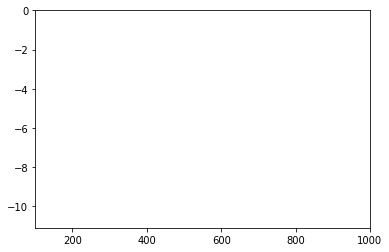

In [115]:
a = plotTables()
a.choose_plot()

# 